In [13]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import mlflow
import time
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from src.preprocessing import clean_telco, clean_bank, get_feature_lists
from src.models import get_models_config, get_param_grids
from src.tuning import get_pipeline
from src.evaluation import calculate_metrics, statistical_comparison

telco_raw = pd.read_csv("/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
bank_raw = pd.read_csv("/data/bank_churn/train.csv")

telco_df = clean_telco(telco_raw)
bank_df = clean_bank(bank_raw)

X_telco= telco_df.drop('Churn', axis=1)
y_telco = telco_df['Churn']
X_bank = bank_df.drop('Exited', axis=1)
y_bank = bank_df['Exited']

telco_cat, telco_num = get_feature_lists(X_telco)
bank_cat, bank_num = get_feature_lists(X_bank)

datasets = {
    "IBM_Telco": (X_telco, y_telco, telco_cat, telco_num),
    "Bank_Churn": (X_bank, y_bank, bank_cat, bank_num)
}

models_config = get_models_config()
param_grids = get_param_grids()
strategies = ["None", "Class_Weights", "SMOTE"]
mlflow.set_experiment("Churn_Performance_Evaluation")

all_results = []

def run_experiment(X, y, dataset_name, cat_cols, num_cols, n_split=5):
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=42)

    for model_name, (model_obj, model_type) in models_config.items():
        for strategy in strategies:
            with mlflow.start_run(run_name=f"{dataset_name}_{model_name}_{strategy}"):
                mlflow.log_params({
                    "dataset": dataset_name,
                    "model_type": model_name,
                    "sampling_strategy": strategy,
                    "cv_folds": n_split
                })

                fold_number = 1
                for train_idx, test_idx in skf.split(X, y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                    ratio = (y_train == 0).sum() / (y_train == 1).sum()
                    pipeline = get_pipeline(model_obj, strategy, cat_cols, num_cols, model_type, pos_weight=ratio)

                    searcher = RandomizedSearchCV(
                        estimator=pipeline,
                        param_distributions=param_grids[model_name],
                        n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42
                    )

                    start_train = time.perf_counter()
                    searcher.fit(X_train, y_train)
                    train_time = time.perf_counter() - start_train

                    best_params = {f"fold_{fold_number}_{k}": v for k, v in searcher.best_params_.items()}
                    mlflow.log_params(best_params)

                    best_model = searcher.best_estimator_
                    y_pred = best_model.predict(X_test)
                    y_prob = best_model.predict_proba(X_test)[:, 1]

                    metrics = calculate_metrics(y_test, y_pred, y_prob)

                    mlflow.log_metrics({f"fold_{fold_number}_{k}": v for k, v in metrics.items()})
                    mlflow.log_metric(f"fold_{fold_number}_train_time", train_time)

                    all_results.append({
                        "dataset": dataset_name,
                        "model": model_name,
                        "strategy": strategy,
                        "fold": fold_number,
                        **metrics
                    })
                    fold_number += 1

                final_ratio = (y == 0).sum() / (y == 1).sum()
                final_pipeline = get_pipeline(model_obj, strategy, cat_cols, num_cols, model_type, pos_weight=final_ratio)

                final_searcher = RandomizedSearchCV(
                    estimator=final_pipeline,
                    param_distributions=param_grids[model_name],
                    n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42
                )
                final_searcher.fit(X, y)

                mlflow.sklearn.log_model(final_searcher.best_estimator_, artifact_path="model")
                print(f"Completed and Saved: {dataset_name} | {model_name} | {strategy}")

for d_name, (X, y, c, n) in datasets.items():
    run_experiment(X, y, d_name, c, n)

results_df = pd.DataFrame(all_results)
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/churn/fold_level_results_N.csv", index=False)

summary_df = (
    results_df
    .groupby(["dataset", "model", "strategy"])
    .agg({
        "accuracy": ["mean", "std"],
        "f1_score": ["mean", "std"],
        "roc_auc": ["mean", "std"],
        "recall": ["mean", "std"]
    })
)

summary_df.to_csv("/content/drive/MyDrive/Colab Notebooks/churn/aggregated_results_N.csv")


telco_stats = statistical_comparison(results_df, "IBM_Telco", metric="roc_auc")
telco_stats.to_csv("/content/drive/MyDrive/Colab Notebooks/churn/telco_stats_N.csv", index=False)

print("Experiment Complete. Results saved to results/ directory.")

2026/02/26 05:36:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/26 05:36:25 INFO mlflow.store.db.utils: Updating database tables
2026/02/26 05:36:27 INFO mlflow.tracking.fluent: Experiment with name 'Churn_Performance_Evaluation' does not exist. Creating a new experiment.
2026/02/26 05:36:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:36:40 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | Logistic | None


2026/02/26 05:36:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:36:55 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | Logistic | Class_Weights


2026/02/26 05:37:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:37:09 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | Logistic | SMOTE


2026/02/26 05:38:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:38:26 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | RandomForest | None


2026/02/26 05:39:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:39:42 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | RandomForest | Class_Weights


2026/02/26 05:41:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:41:39 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | RandomForest | SMOTE


2026/02/26 05:42:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:42:07 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | XGB | None


2026/02/26 05:42:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:42:35 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | XGB | Class_Weights


2026/02/26 05:44:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:44:17 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: IBM_Telco | XGB | SMOTE


2026/02/26 05:44:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:44:45 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | Logistic | None


2026/02/26 05:45:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:45:15 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | Logistic | Class_Weights


2026/02/26 05:49:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 05:49:39 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | Logistic | SMOTE


2026/02/26 06:09:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 06:09:10 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | RandomForest | None


2026/02/26 06:28:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 06:28:40 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | RandomForest | Class_Weights


2026/02/26 07:10:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 07:10:39 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | RandomForest | SMOTE


2026/02/26 07:13:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 07:13:25 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | XGB | None


2026/02/26 07:16:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 07:16:16 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | XGB | Class_Weights


2026/02/26 07:21:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 07:21:03 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Completed and Saved: Bank_Churn | XGB | SMOTE
Experiment Complete. Results saved to results/ directory.


In [17]:
bank_stats = statistical_comparison(results_df, "Bank_Churn", metric="roc_auc")
bank_stats.to_csv("/content/drive/MyDrive/Colab Notebooks/churn/bank_statistical_tests_N.csv", index=False)

In [18]:
tbl = results_df.groupby(['dataset', 'model', 'strategy']).agg(
    AUC_mean=('roc_auc', 'mean'),
    AUC_std=('roc_auc', 'std'),
    F1_mean=('f1_score', 'mean'),
    F1_std=('f1_score', 'std'),
    Recall_mean=('recall', 'mean'),
    Recall_std=('recall', 'std'),
    Precision_mean=('precision', 'mean'),
    Precision_std=('precision', 'std'),
).round(4).reset_index()

tbl['ROC-AUC'] = tbl.apply(lambda r: f"{r.AUC_mean:.4f} ± {r.AUC_std:.4f}", axis=1)
tbl['F1-Score'] = tbl.apply(lambda r: f"{r.F1_mean:.4f} ± {r.F1_std:.4f}", axis=1)
tbl['Recall']   = tbl.apply(lambda r: f"{r.Recall_mean:.4f} ± {r.Recall_std:.4f}", axis=1)
tbl['Precision'] = tbl.apply(lambda r: f"{r.Precision_mean:.4f} ± {r.Precision_std:.4f}", axis=1)

print("Table 1: Model Performance Summary (Mean ± Std over 5 Folds)")
display(tbl[['dataset','model','strategy','ROC-AUC','F1-Score','Recall','Precision']])

Table 1: Model Performance Summary (Mean ± Std over 5 Folds)


,dataset,model,strategy,ROC-AUC,F1-Score,Recall,Precision
0,Bank_Churn,Logistic,Class_Weights,0.8187 ± 0.0011,0.5588 ± 0.0018,0.7375 ± 0.0017,0.4499 ± 0.0021
1,Bank_Churn,Logistic,None,0.8177 ± 0.0013,0.4942 ± 0.0055,0.3831 ± 0.0063,0.6963 ± 0.0085
2,Bank_Churn,Logistic,SMOTE,0.8187 ± 0.0011,0.5602 ± 0.0014,0.7361 ± 0.0027,0.4521 ± 0.0019
3,Bank_Churn,RandomForest,Class_Weights,0.8830 ± 0.0011,0.6547 ± 0.0032,0.7061 ± 0.0045,0.6102 ± 0.0028
4,Bank_Churn,RandomForest,None,0.8855 ± 0.0012,0.6249 ± 0.0033,0.5364 ± 0.0030,0.7484 ± 0.0039
5,Bank_Churn,RandomForest,SMOTE,0.8849 ± 0.0012,0.6420 ± 0.0051,0.5863 ± 0.0075,0.7096 ± 0.0079
6,Bank_Churn,XGB,Class_Weights,0.8874 ± 0.0033,0.6436 ± 0.0036,0.7846 ± 0.0151,0.5458 ± 0.0112
7,Bank_Churn,XGB,None,0.8896 ± 0.0015,0.6386 ± 0.0028,0.5604 ± 0.0018,0.7424 ± 0.0048
8,Bank_Churn,XGB,SMOTE,0.8871 ± 0.0019,0.6455 ± 0.0043,0.5880 ± 0.0034,0.7155 ± 0.0103
9,IBM_Telco,Logistic,Class_Weights,0.8444 ± 0.0158,0.6266 ± 0.0103,0.7988 ± 0.0231,0.5155 ± 0.0058


In [19]:
# Highlight best configuration per dataset
print("Best configuration per dataset (by ROC-AUC):")
for ds in ['IBM_Telco', 'Bank_Churn']:
    subset = tbl[tbl['dataset'] == ds].sort_values('AUC_mean', ascending=False)
    best = subset.iloc[0]
    print(f"\n{ds}: {best['model']} + {best['strategy']} → AUC={best['AUC_mean']:.4f}, F1={best['F1_mean']:.4f}")

Best configuration per dataset (by ROC-AUC):

IBM_Telco: XGB + Class_Weights → AUC=0.8465, F1=0.6302

Bank_Churn: XGB + None → AUC=0.8896, F1=0.6386


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

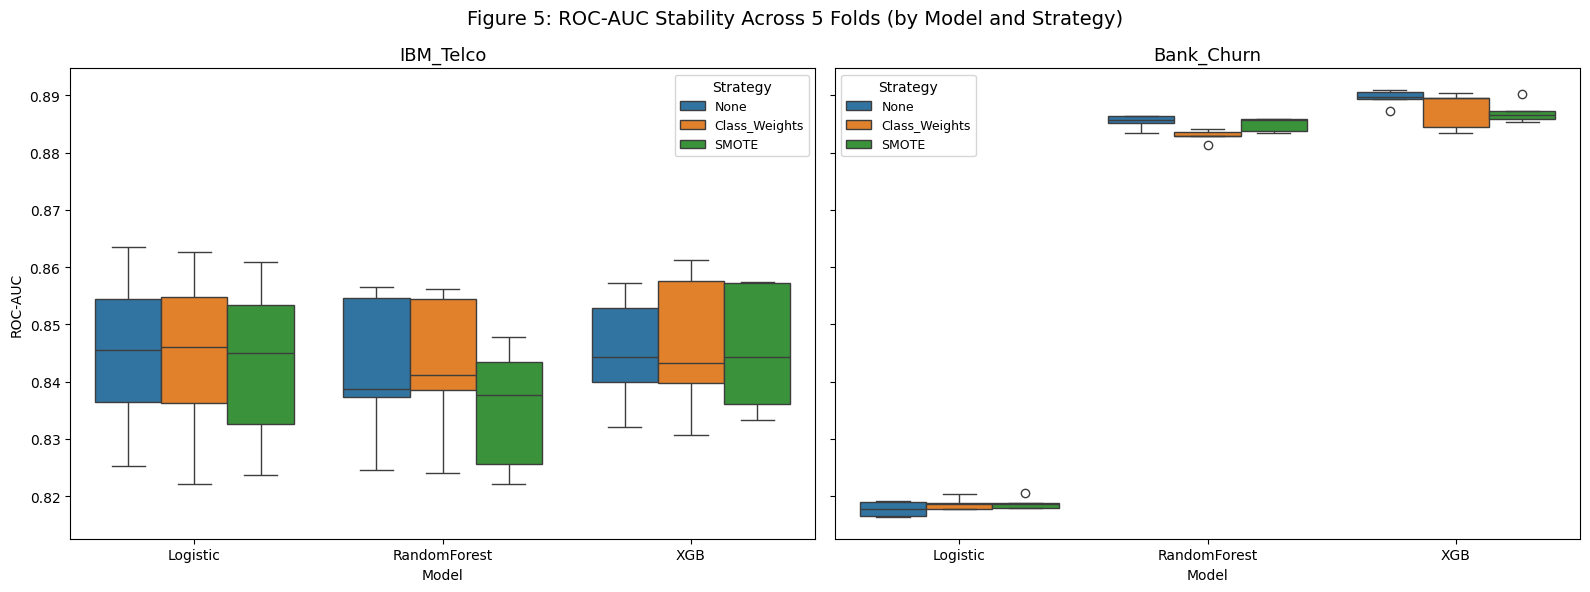

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for ax, ds in zip(axes, ['IBM_Telco', 'Bank_Churn']):
    data = results_df[results_df['dataset'] == ds]
    sns.boxplot(data=data, x='model', y='roc_auc', hue='strategy', ax=ax)
    ax.set_title(f'{ds}', fontsize=13)
    ax.set_xlabel('Model')
    ax.set_ylabel('ROC-AUC')
    ax.legend(title='Strategy', fontsize=9)
plt.suptitle('Figure 5: ROC-AUC Stability Across 5 Folds (by Model and Strategy)', fontsize=14)
plt.tight_layout()
plt.savefig('fig5_roc_auc_stability.png', bbox_inches='tight')
plt.show()

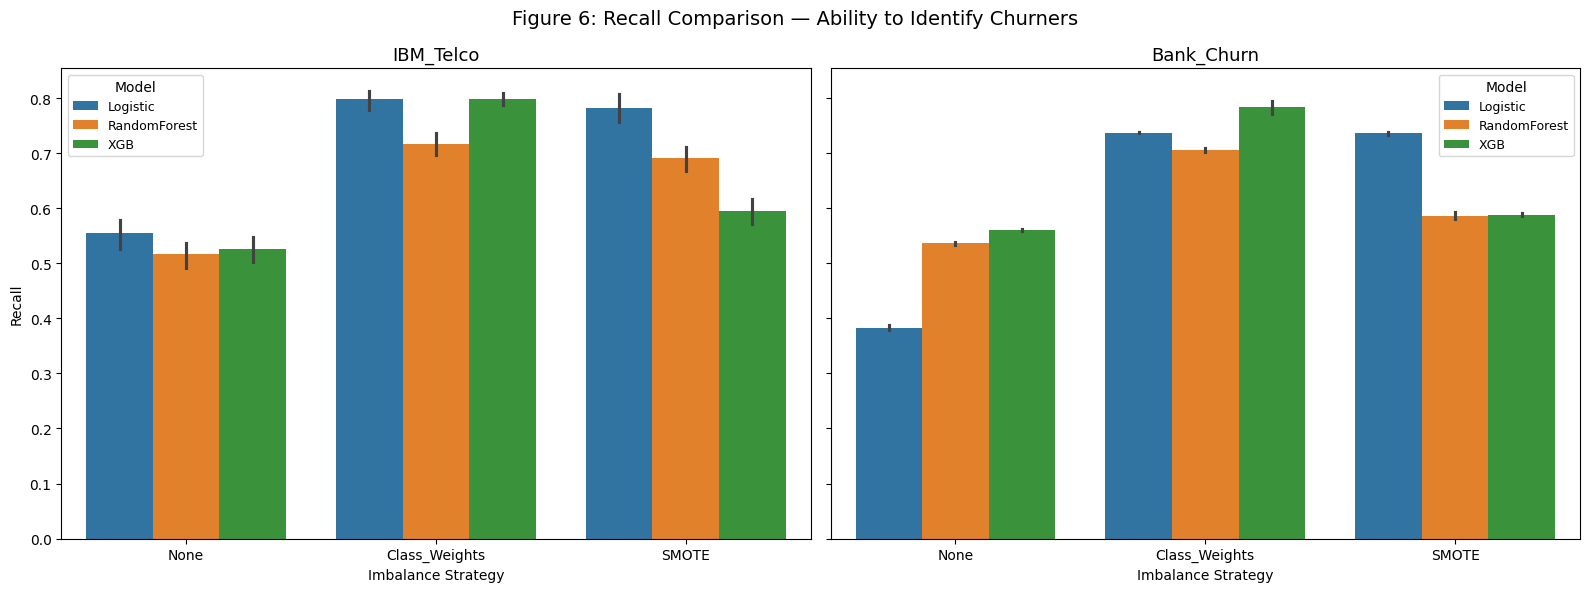

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for ax, ds in zip(axes, ['IBM_Telco', 'Bank_Churn']):
    data = results_df[results_df['dataset'] == ds]
    sns.barplot(data=data, x='strategy', y='recall', hue='model', ax=ax)
    ax.set_title(f'{ds}', fontsize=13)
    ax.set_xlabel('Imbalance Strategy')
    ax.set_ylabel('Recall')
    ax.legend(title='Model', fontsize=9)
plt.suptitle('Figure 6: Recall Comparison — Ability to Identify Churners', fontsize=14)
plt.tight_layout()
plt.savefig('fig6_recall_comparison.png', bbox_inches='tight')
plt.show()

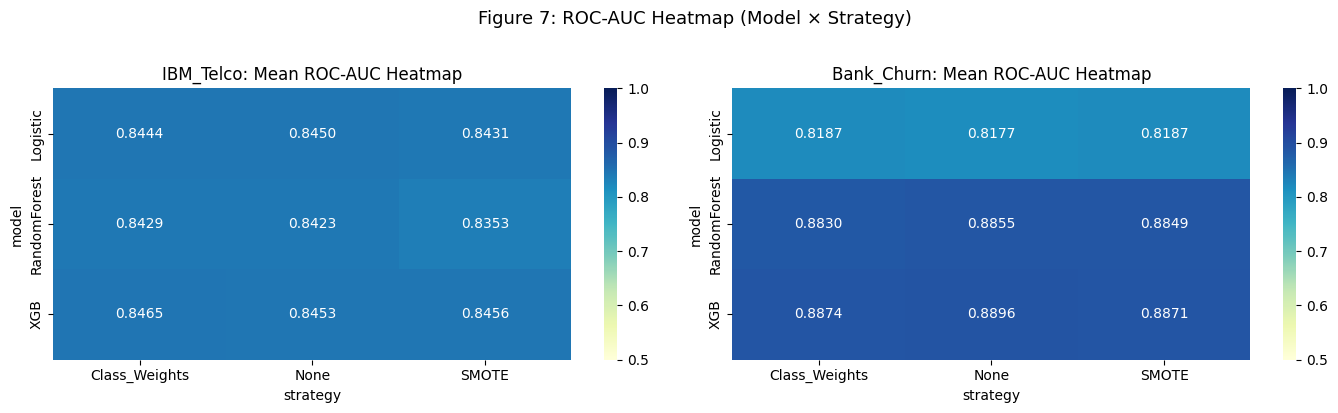

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, ds in zip(axes, ['IBM_Telco', 'Bank_Churn']):
    pivot = results_df[results_df['dataset'] == ds].groupby(['model','strategy'])['roc_auc'].mean().unstack()
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax, vmin=0.5, vmax=1.0)
    ax.set_title(f'{ds}: Mean ROC-AUC Heatmap', fontsize=12)
plt.suptitle('Figure 7: ROC-AUC Heatmap (Model × Strategy)', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('fig7_auc_heatmap.png', bbox_inches='tight')
plt.show()

In [27]:
def display_sig_results(stats_df, dataset_name, metric):
    print(f"\n{'='*60}")
    print(f"Statistical Tests: {dataset_name} | Metric: {metric}")
    print(f"{'='*60}")
    display_cols = ['strategy','model_A','model_B','mean_A','mean_B',
                    't_p_value','wilcoxon_p_value','cohens_d']
    df = stats_df[display_cols].copy()
    df['significant (p<0.05)'] = df['t_p_value'] < 0.05
    display(df.round(4))

display_sig_results(telco_stats, "IBM_Telco", "roc_auc")
display_sig_results(bank_stats, "Bank_Churn", "roc_auc")


Statistical Tests: IBM_Telco | Metric: roc_auc


,strategy,model_A,model_B,mean_A,mean_B,t_p_value,wilcoxon_p_value,cohens_d,significant (p<0.05)
0,None,Logistic,RandomForest,0.8450,0.8423,0.1894,0.4375,0.7063,False
1,None,Logistic,XGB,0.8450,0.8453,0.9238,1.0000,-0.0456,False
2,None,RandomForest,XGB,0.8423,0.8453,0.1540,0.1875,-0.7851,False
3,Class_Weights,Logistic,RandomForest,0.8444,0.8429,0.4512,0.6250,0.3730,False
4,Class_Weights,Logistic,XGB,0.8444,0.8465,0.4584,0.4375,-0.3666,False
5,Class_Weights,RandomForest,XGB,0.8429,0.8465,0.0451,0.0625,-1.2874,True
6,SMOTE,Logistic,RandomForest,0.8431,0.8353,0.0152,0.0625,1.8210,True
7,SMOTE,Logistic,XGB,0.8431,0.8456,0.3114,0.3125,-0.5177,False
8,SMOTE,RandomForest,XGB,0.8353,0.8456,0.0009,0.0625,-3.9064,True



Statistical Tests: Bank_Churn | Metric: roc_auc


,strategy,model_A,model_B,mean_A,mean_B,t_p_value,wilcoxon_p_value,cohens_d,significant (p<0.05)
0,None,Logistic,RandomForest,0.8177,0.8855,0.0000,0.0625,-35.0821,True
1,None,Logistic,XGB,0.8177,0.8896,0.0000,0.0625,-34.1335,True
2,None,RandomForest,XGB,0.8855,0.8896,0.0000,0.0625,-13.5012,True
3,Class_Weights,Logistic,RandomForest,0.8187,0.8830,0.0000,0.0625,-53.3814,True
4,Class_Weights,Logistic,XGB,0.8187,0.8874,0.0000,0.0625,-16.3788,True
5,Class_Weights,RandomForest,XGB,0.8830,0.8874,0.0387,0.1250,-1.3562,True
6,SMOTE,Logistic,RandomForest,0.8187,0.8849,0.0000,0.0625,-48.2903,True
7,SMOTE,Logistic,XGB,0.8187,0.8871,0.0000,0.0625,-58.7524,True
8,SMOTE,RandomForest,XGB,0.8849,0.8871,0.0261,0.0625,-1.5419,True


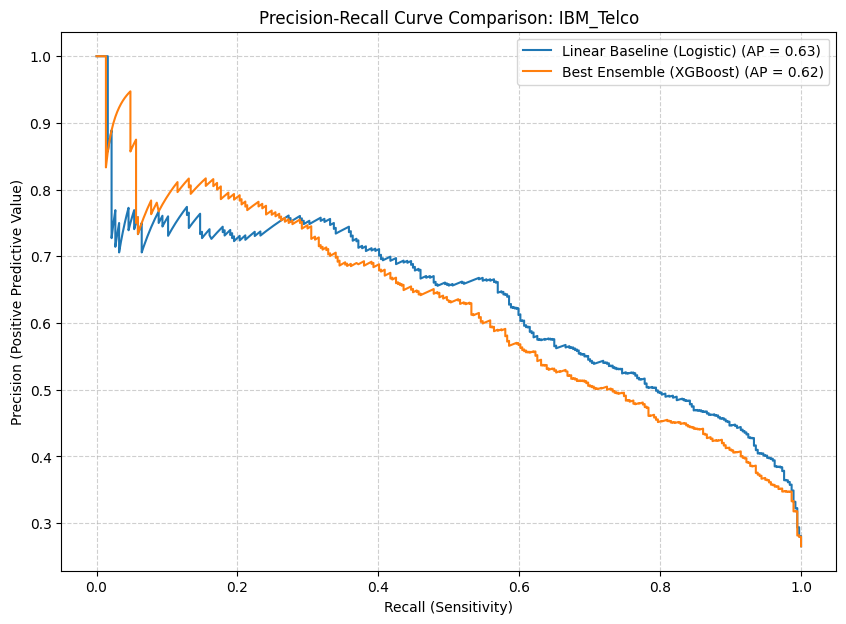

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

def plot_pr_comparison(dataset_name="IBM_Telco"):
    X, y, cat_cols, num_cols = datasets[dataset_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    comparison_models = {
        "Linear Baseline (Logistic)": ("Logistic", "linear"),
        "Best Ensemble (XGBoost)": ("XGB", "tree")
    }

    plt.figure(figsize=(10, 7))
    strategy = "Class_Weights"

    for label, (m_key, m_type) in comparison_models.items():
        # Extract the actual model estimator from models_config
        model_estimator = models_config[m_key][0]

        ratio = (y_train == 0).sum() / (y_train == 1).sum()

        # Pass the model_estimator as the 'model' argument and m_type as 'model_type'
        pipeline = get_pipeline(model_estimator, strategy, cat_cols, num_cols, m_type, pos_weight=ratio)
        pipeline.fit(X_train, y_train)

        y_prob = pipeline.predict_proba(X_test)[:, 1]

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)

        plt.plot(recall, precision, label=f'{label} (AP = {ap:.2f})')

    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (Positive Predictive Value)')
    plt.title(f'Precision-Recall Curve Comparison: {dataset_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"{dataset_name}_pr_curve.png", dpi=300)
    plt.show()

plot_pr_comparison("IBM_Telco")